In [ ]:

'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
!pip install opencv-python

In [ ]:
#IMPORT LIBRARY OF SEGMENTATION

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed

In [ ]:


def ShowImage(title, img, ctype):
    plt.figure(figsize=(10, 10))      #SET THE FIGURE SIZE TO 10X10 INCHES
    if ctype == 'bgr':
        b, g, r = cv2.split(img)       #SPLIT IMAGE INTO B,G,R
        rgb_img = cv2.merge([r, g, b])     #MERGE THE CHANNEL IN R,G,B ORDER
        plt.imshow(rgb_img)
    elif ctype == 'hsv':
        rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)    #CONVERT IMAGE HSV TO RGB(HUE,SATURATION,VALUE)
        plt.imshow(rgb)
    elif ctype == 'gray':
        plt.imshow(img, cmap='gray')        #DISPLAY IN GRAP SCALE FORMAT
    elif ctype == 'rgb':
        plt.imshow(img)                     #DISPLAY IN RGB FORMAT
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()


In [ ]:
'''

  ^ABOVE CODE'S EXPLAINATION

     ->>converting from HSV to RGB is essential for correctly displaying images on most screens
          and for compatibility with image processing tools that expect RGB input.

     ->>When you perform color detection, object recognition, or any operation where
         color characteristics are essential, you might work with an image in the HSV
         color space to easily manipulate the hue and saturation. However, when
         displaying the result or further processing it with common image libraries,
         you typically convert it back to RGB.

'''


"\n\n  ^ABOVE CODE'S EXPLAINATION\n\n     ->>converting from HSV to RGB is essential for correctly displaying images on most screens\n          and for compatibility with image processing tools that expect RGB input.\n\n     ->>When you perform color detection, object recognition, or any operation where\n         color characteristics are essential, you might work with an image in the HSV\n         color space to easily manipulate the hue and saturation. However, when\n         displaying the result or further processing it with common image libraries,\n         you typically convert it back to RGB.\n\n"

In [ ]:
"""
from google.colab import files
from PIL import Image
import io

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_path]))
    print(f"Image {image_path} uploaded successfully!")
else:
    print("No image uploaded, exiting...")
    exit()
"""



'\nfrom google.colab import files\nfrom PIL import Image\nimport io\n\n# Upload the image file\nuploaded = files.upload()\n\n# Check if an image was uploaded\nif uploaded:\n    image_path = next(iter(uploaded))\n    image = Image.open(io.BytesIO(uploaded[image_path]))\n    print(f"Image {image_path} uploaded successfully!")\nelse:\n    print("No image uploaded, exiting...")\n    exit()\n'

In [ ]:
from google.colab import files
from PIL import Image
import io

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))  # Get the name of the uploaded image file
    image = Image.open(io.BytesIO(uploaded[image_path]))

    # Save the uploaded image to the local filesystem in Colab
    local_image_path = '/content/' + image_path
    image.save(local_image_path)
    print(f"Image {image_path} uploaded successfully and saved as {local_image_path}!")
else:
    print("No image uploaded, exiting...")
    exit()


Saving Te-glTr_0005.jpg to Te-glTr_0005.jpg
Image Te-glTr_0005.jpg uploaded successfully and saved as /content/Te-glTr_0005.jpg!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


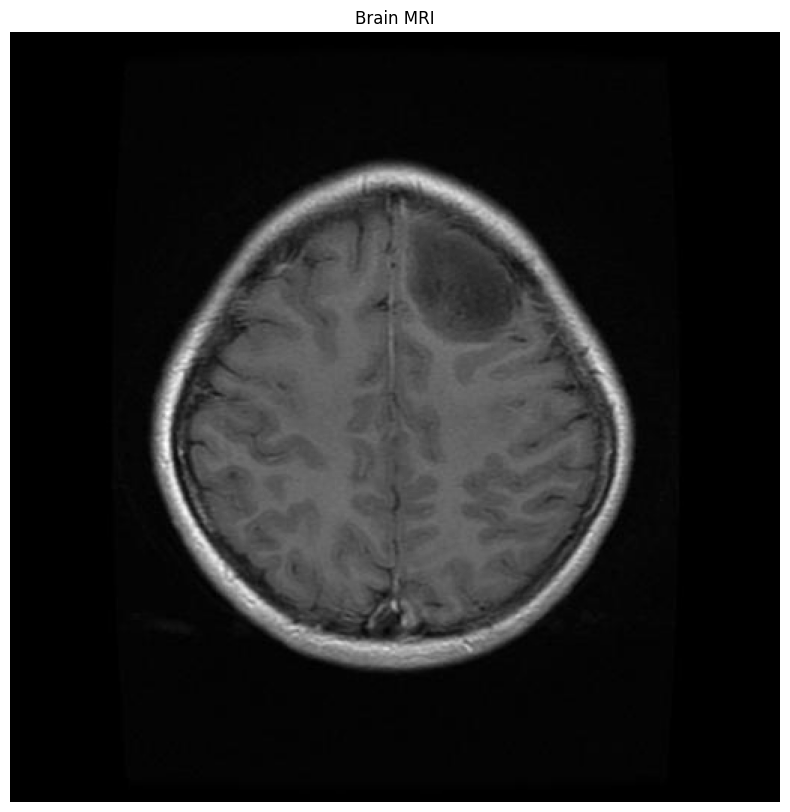

In [ ]:
# READ THE IMAGE THAT WE HAVE UPLOADED

img = cv2.imread(image_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



ShowImage('Brain MRI', gray, 'gray')

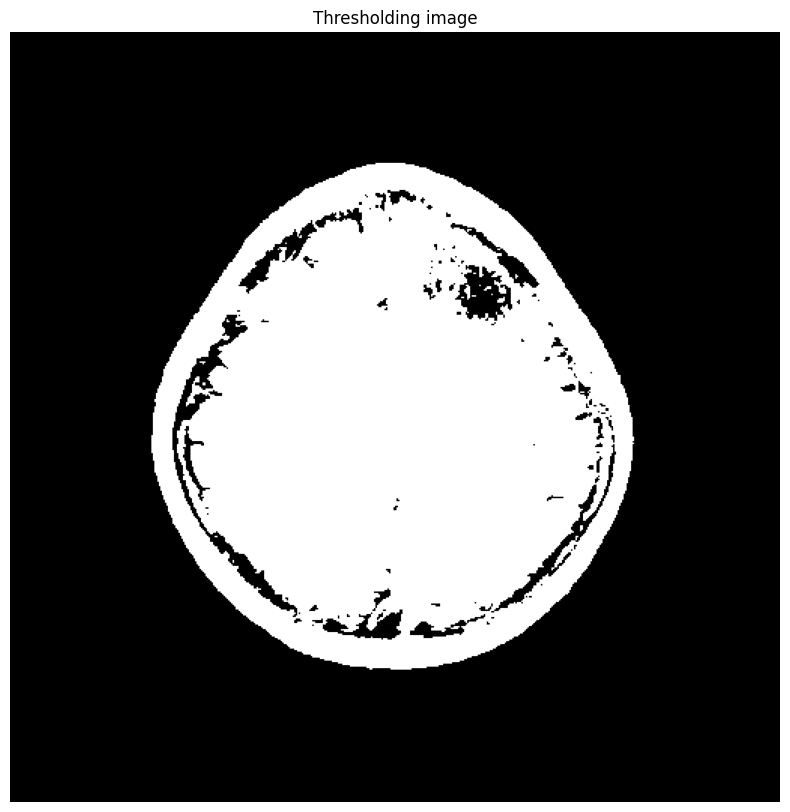

In [ ]:
# THRESHOLDING USING OTSU'S METHOD

# OTSU'S METHOD AUTOMATICALLY CALCULATES THE OPTIMAL THRESHOLD VALUE TO SEPARATE THE FOREGROUND AND BACKGROUND
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

# DISPLAY THE THRESHOLDED IMAGE
ShowImage('Thresholding image', thresh, 'gray')


In [ ]:
# CONNECTED COMPONENTS ANALYSIS

# THIS STEP LABELS DIFFERENT CONNECTED COMPONENTS IN THE BINARY IMAGE. EACH CONNECTED COMPONENT GETS A UNIQUE LABEL.
ret, markers = cv2.connectedComponents(thresh)

# CALCULATE THE AREA TAKEN BY EACH COMPONENT, EXCLUDING THE BACKGROUND (LABEL 0)
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0]

# IDENTIFY THE LABEL OF THE LARGEST CONNECTED COMPONENT
largest_component = np.argmax(marker_area) + 1  # ADD 1 BECAUSE LABEL 0 IS BACKGROUND

# CREATE A MASK FOR THE LARGEST CONNECTED COMPONENT (WHICH CORRESPONDS TO THE BRAIN IN THIS CONTEXT)
brain_mask = markers == largest_component

# CREATE A COPY OF THE ORIGINAL IMAGE TO APPLY THE BRAIN MASK
brain_out = img.copy()

# REMOVE ALL REGIONS FROM THE IMAGE EXCEPT FOR THE LARGEST COMPONENT (BRAIN)
brain_out[brain_mask == False] = (0, 0, 0)


In [ ]:
# NOISE REMOVAL

img = cv2.imread(image_path)#READ THE IMAGE PATH


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # CONVERT THE IMAGE TO GRAYSCALE

# APPLY INVERSE BINARY THRESHOLDING WITH OTSU'S METHOD
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


# MORPHOLOGICAL OPENING IS USED HERE TO REMOVE SMALL WHITE NOISE FROM THE FOREGROUND
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# DEFINE THE SURE BACKGROUND AREA BY DILATING THE IMAGE
# DILATION INCREASES THE WHITE REGION, HELPING TO DEFINE THE BACKGROUND MORE CLEARLY
sure_bg = cv2.dilate(opening, kernel, iterations=3)


In [ ]:
# DEFINE THE SURE FOREGROUND AREA USING DISTANCE TRANSFORM
# THE DISTANCE TRANSFORM CALCULATES THE DISTANCE FROM EACH PIXEL TO THE NEAREST ZERO PIXEL (BACKGROUND)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# THRESHOLD THE DISTANCE TRANSFORMED IMAGE TO GET THE SURE FOREGROUND
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# CONVERT SURE FOREGROUND TO UINT8 FORMAT
sure_fg = np.uint8(sure_fg)

# SUBTRACT THE SURE FOREGROUND FROM THE SURE BACKGROUND TO GET THE UNKNOWN REGION
unknown = cv2.subtract(sure_bg, sure_fg)


In [ ]:
# MARKER LABELING
# LABEL THE SURE FOREGROUND, WITH LABELS STARTING FROM 1
ret, markers = cv2.connectedComponents(sure_fg)

# INCREMENT ALL LABEL VALUES BY 1, SO THAT THE BACKGROUND IS LABELED AS 1 INSTEAD OF 0
markers = markers + 1

# MARK THE UNKNOWN REGION WITH ZERO
markers[unknown == 255] = 0

# APPLY WATERSHED ALGORITHM
# THE WATERSHED ALGORITHM TREATS THE IMAGE LIKE A TOPOGRAPHIC MAP AND "FLOODS" REGIONS FROM THE MARKERS
markers = cv2.watershed(img, markers)

# MARK THE BOUNDARIES IDENTIFIED BY THE WATERSHED ALGORITHM
# BOUNDARIES ARE MARKED WITH -1, SO WE COLOR THOSE PIXELS RED (255, 0, 0)
img[markers == -1] = [255, 0, 0]


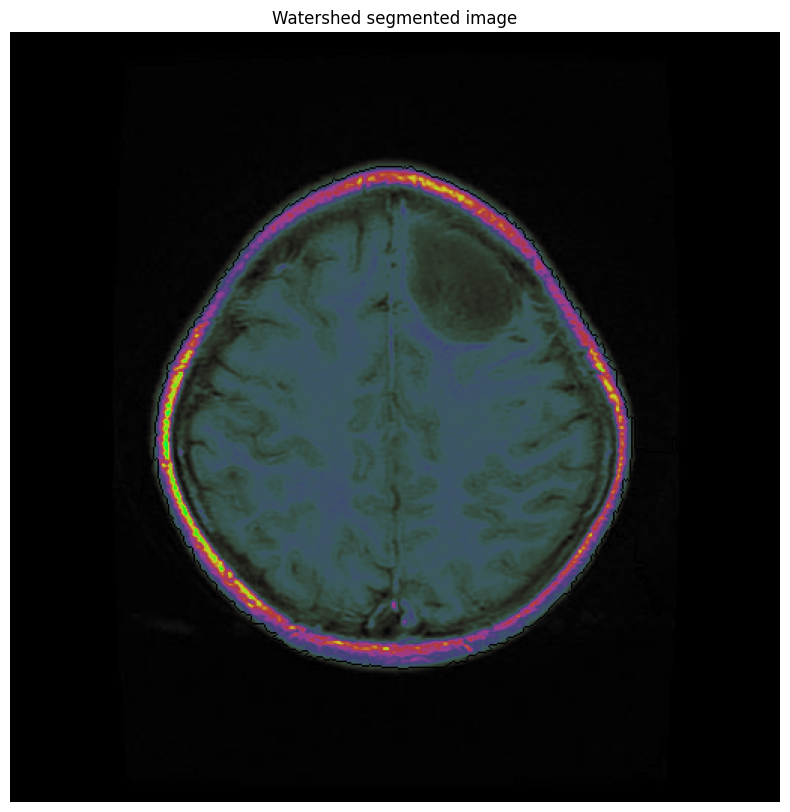

In [ ]:
# CONVERT THE IMAGE FROM HSV TO RGB (IF NEEDED)
im1 = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

# DISPLAY THE WATERSHED-SEGMENTED IMAGE
ShowImage('Watershed segmented image', im1, 'gray')



Image /content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Testing/notumor/Te-noTr_0000.jpg loaded successfully!
Estimated Tumor Volume: 8679.50 cubic millimeters
Total Slice Volume: 27848.00 cubic millimeters
Percentage of Tumor Spread: 31.17%


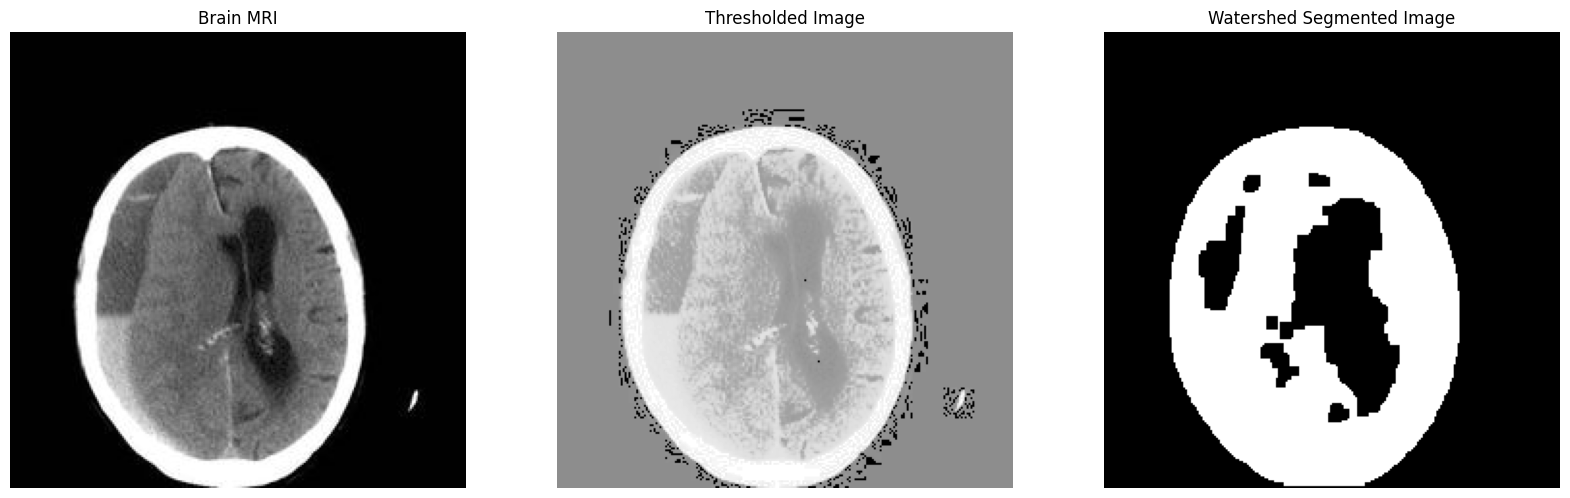

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted class: Meningioma


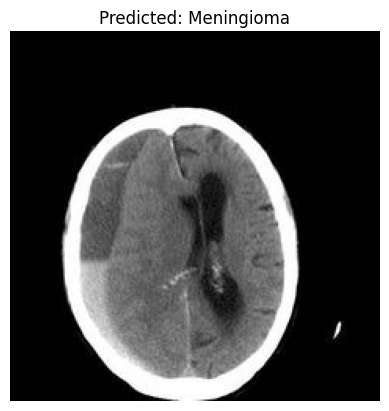

In [ ]:
# Required Libraries
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_efficientnetb0.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    print(f"Predicted class: {predicted_class}")

    return predicted_class

# Direct image path
image_path = '/content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Testing/notumor/Te-noTr_0000.jpg'  # Replace with the actual path to your image

# Load and preprocess the image
try:
    image = Image.open(image_path)
    print(f"Image {image_path} loaded successfully!")

    # Convert to grayscale
    img_gray = np.array(image.convert('L'))

    # Set your pixel spacing and slice thickness
    pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
    slice_thickness = 2.0  # Replace with the actual slice thickness in mm

    # Calculate tumor volume and percentage
    preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
        img_gray, pixel_spacing, slice_thickness)

    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 10))

    # Subplot 1: Displaying the Grayscale Brain MRI Image
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
    plt.imshow(img_gray, cmap='gray')
    plt.title('Brain MRI')
    plt.axis('off')

    # Subplot 2: Displaying the Thresholded Image
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
    plt.imshow(preprocessed_img, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')

    # Subplot 3: Displaying the Watershed Segmented Image
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Watershed Segmented Image')
    plt.axis('off')

    # Show the comparison
    plt.show()

    # Perform classification
    predicted_class = classify_image(image)

    # Display the predicted class
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"File {image_path} not found. Please check the path and try again.")


In [ ]:
# Required Libraries
from google.colab import files
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    print(f"Predicted class: {predicted_class}")

    return predicted_class

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_path]))

    # Save the uploaded image to the local filesystem in Colab
    local_image_path = '/content/' + image_path
    image.save(local_image_path)
    print(f"Image {image_path} uploaded successfully and saved as {local_image_path}!")

    # Load and preprocess the image
    img_gray = np.array(image.convert('L'))

    # Set your pixel spacing and slice thickness
    pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
    slice_thickness = 2.0  # Replace with the actual slice thickness in mm

    # Calculate tumor volume and percentage
    preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
        img_gray, pixel_spacing, slice_thickness)

   # Create a figure with multiple subplots
    plt.figure(figsize=(20, 10))

    # Subplot 1: Displaying the Grayscale Brain MRI Image
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
    plt.imshow(gray, cmap='gray')
    plt.title('Brain MRI')
    plt.axis('off')

    # Subplot 2: Displaying the Thresholded Image
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
    plt.imshow(thresh, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')

    # Subplot 3: Displaying the Watershed Segmented Image
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
    plt.imshow(im1, cmap='gray')
    plt.title('Watershed Segmented Image')
    plt.axis('off')

    # Show the comparison
    plt.show()

# Set your pixel spacing and slice thickness
    pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
    slice_thickness = 2.0  # Replace with the actual slice thickness in mm

    # Calculate tumor volume and percentage
    preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
        img_gray, pixel_spacing, slice_thickness)


    # Perform classification
    predicted_class = classify_image(image)

    # Display the predicted class
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

else:
    print("No image uploaded, exiting...")






In [ ]:
# Required Libraries
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_densenet.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

# Direct image path
image_path = '/content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Testing/notumor/Te-noTr_0000.jpg'  # Replace with the actual path to your image

# Load and preprocess the image
try:
    image = Image.open(image_path)
    print(f"Image {image_path} loaded successfully!")

    # Perform classification
    predicted_class = classify_image(image)
    print(f"Predicted class: {predicted_class}")

    if predicted_class == "No Tumor":
        print("No tumor detected in the image.")
    else:
        # Convert to grayscale
        img_gray = np.array(image.convert('L'))

        # Set your pixel spacing and slice thickness
        pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
        slice_thickness = 2.0  # Replace with the actual slice thickness in mm

        # Calculate tumor volume and percentage
        preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
            img_gray, pixel_spacing, slice_thickness)

        print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
        print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

        # Create a figure with multiple subplots
        plt.figure(figsize=(20, 10))

        # Subplot 1: Displaying the Grayscale Brain MRI Image
        plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
        plt.imshow(img_gray, cmap='gray')
        plt.title('Brain MRI')
        plt.axis('off')

        # Subplot 2: Displaying the Thresholded Image
        plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
        plt.imshow(preprocessed_img, cmap='gray')
        plt.title('Thresholded Image')
        plt.axis('off')

        # Subplot 3: Displaying the Watershed Segmented Image
        plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
        plt.imshow(segmented_image, cmap='gray')
        plt.title('Watershed Segmented Image')
        plt.axis('off')

        # Show the comparison
        plt.show()

        # Display the predicted class
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

except FileNotFoundError:
    print(f"File {image_path} not found. Please check the path and try again.")


In [ ]:
from google.colab import files
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image):
    """
    Applies histogram equalization to improve contrast in grayscale MRI image.

    Parameters:
    - image: numpy array, grayscale image of an MRI slice.

    Returns:
    - equalized_image: numpy array, contrast-enhanced image.
    """
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

def segment_image(image):
    """
    Segments the tumor from a grayscale MRI image using thresholding,
    watershed algorithm, and morphological operations.

    Parameters:
    - image: numpy array, grayscale image of an MRI slice.

    Returns:
    - segmented_image: numpy array, binary image with the tumor region.
    """
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

def remove_small_components(segmented_image, min_size=100):
    """
    Removes small components in the segmented binary image that are not part of the tumor.

    Parameters:
    - segmented_image: numpy array, binary image with the tumor region.
    - min_size: int, minimum size of components to keep.

    Returns:
    - filtered_image: numpy array, binary image with small components removed.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]  # Get sizes of all components except the background
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

def calculate_tumor_volume_for_image(image_path, pixel_spacing, slice_thickness):
    """
    Calculates the volume of a tumor from a segmented 2D MRI slice and the total slice volume.

    Parameters:
    - image_path: str, path to the MRI slice.
    - pixel_spacing: tuple (float, float), pixel spacing in millimeters (e.g., (0.5, 0.5)).
    - slice_thickness: float, slice thickness in millimeters.

    Returns:
    - volume: float, estimated tumor volume in cubic millimeters.
    - percentage_spread: float, percentage of the slice volume occupied by the tumor.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Error reading image: {image_path}")

    preprocessed_img = preprocess_image(img)
    segmented_image = segment_image(preprocessed_img)
    segmented_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(segmented_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]  # mm^2
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = img.shape[0] * img.shape[1]
    total_slice_area = total_pixels * pixel_area  # Total area of the slice in mm^2
    total_volume = total_slice_area * slice_thickness  # Total volume in cubic millimeters

    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")



    return tumor_volume, total_volume, percentage_spread




# Create a figure with multiple subplots
plt.figure(figsize=(20, 10))

# Subplot 1: Displaying the Grayscale Brain MRI Image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
plt.imshow(gray, cmap='gray')
plt.title('Brain MRI')
plt.axis('off')

# Subplot 2: Displaying the Thresholded Image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

# Subplot 3: Displaying the Watershed Segmented Image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
plt.imshow(im1, cmap='gray')
plt.title('Watershed Segmented Image')
plt.axis('off')

# Show the comparison
plt.show()



# Now you can use the local_image_path in the calculation function
pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
slice_thickness = 2.0  # Replace with the actual slice thickness in mm

# Calculate tumor volume for the single image and display results
calculate_tumor_volume_for_image(local_image_path, pixel_spacing, slice_thickness)


In [ ]:
# Required Libraries
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary
# Required Libraries
from google.colab import files
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Skull stripping function
def remove_skull(image):
    # Apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)

    # Use morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Remove the skull from the original image
    skull_stripped_image = cv2.bitwise_and(image, image, mask=binary_mask)

    return skull_stripped_image, binary_mask

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_densenet.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    print(f"Predicted class: {predicted_class}")

    return predicted_class

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_path]))

    # Save the uploaded image to the local filesystem in Colab
    local_image_path = '/content/' + image_path
    image.save(local_image_path)
    print(f"Image {image_path} uploaded successfully and saved as {local_image_path}!")

    # Load and preprocess the image
    img_gray = np.array(image.convert('L'))

    # Remove the skull
    skull_stripped_image, skull_mask = remove_skull(img_gray)

    # Set your pixel spacing and slice thickness
    pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
    slice_thickness = 2.0  # Replace with the actual slice thickness in mm

    # Calculate tumor volume and percentage on the skull-stripped image
    preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(skull_stripped_image, pixel_spacing, slice_thickness)

    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 10))

    # Subplot 1: Displaying the Skull Stripped Image
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
    plt.imshow(skull_stripped_image, cmap='gray')
    plt.title('Skull Stripped Image')
    plt.axis('off')

    # Subplot 2: Displaying the Thresholded Image
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')
    plt.axis('off')

    # Subplot 3: Displaying the Filtered Image
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    # Show the comparison
    plt.show()

    # Perform classification on the original image
    predicted_class = classify_image(image)

    # Display the predicted class
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

else:
    print("No image uploaded, exiting...")

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_efficientnetb0.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    print(f"Predicted class: {predicted_class}")

    return predicted_class
'''
# Path to the uploaded image (from previous upload)
local_image_path = '/content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Testing/notumor/Te-noTr_0000.jpg'  # Replace with the path from the previous upload

# Load and preprocess the image
image = Image.open(local_image_path)
img_gray = np.array(image.convert('L'))
'''
# Set your pixel spacing and slice thickness
pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
slice_thickness = 2.0  # Replace with the actual slice thickness in mm

# Calculate tumor volume and percentage
preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
    img_gray, pixel_spacing, slice_thickness)

# Create a figure with subplots
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(preprocessed_img, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.show()

# Perform classification
predicted_class = classify_image(image)

# Display the predicted class
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [ ]:
# Required Libraries
from google.colab import files
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.optimizers import Adamax

# Improved Skull Stripping function
def remove_skull(image):
    # Convert to float32 for more precision during processing
    image_float = image.astype(np.float32)

    # Apply adaptive histogram equalization to enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image.astype(np.uint8))

    # Thresholding to create a binary mask
    _, binary_mask = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use morphological operations to improve the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Remove small components from the mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    sizes = stats[1:, -1]  # Ignore the background label (0)
    mask_filtered = np.zeros_like(binary_mask)

    # Keep only the largest component, assuming it's the brain
    largest_component = np.argmax(sizes) + 1
    mask_filtered[labels == largest_component] = 255

    # Remove the skull from the original image using the refined mask
    skull_stripped_image = cv2.bitwise_and(image, image, mask=mask_filtered)

    return skull_stripped_image, mask_filtered

# Preprocessing function
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Segmentation function
def segment_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    ret, markers = cv2.connectedComponents(binary)
    markers = markers + 1
    unknown = cv2.subtract(binary, binary)
    markers[unknown == 255] = 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    binary[markers == -1] = 0  # Mark boundaries

    return binary

# Remove small components
def remove_small_components(segmented_image, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)
    sizes = stats[1:, -1]
    filtered_image = np.zeros_like(segmented_image)

    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            filtered_image[labels == i + 1] = 255

    return filtered_image

# Calculate tumor volume and percentage
def calculate_tumor_volume_for_image(image, pixel_spacing, slice_thickness):
    preprocessed_img = preprocess_image(image)
    segmented_image = segment_image(preprocessed_img)
    filtered_image = remove_small_components(segmented_image)

    tumor_pixels = np.sum(filtered_image == 255)
    pixel_area = pixel_spacing[0] * pixel_spacing[1]
    slice_area = tumor_pixels * pixel_area
    tumor_volume = slice_area * slice_thickness

    total_pixels = image.shape[0] * image.shape[1]
    total_slice_area = total_pixels * pixel_area
    total_volume = total_slice_area * slice_thickness
    percentage_spread = (tumor_volume / total_volume) * 100

    print(f"Estimated Tumor Volume: {tumor_volume:.2f} cubic millimeters")
    print(f"Total Slice Volume: {total_volume:.2f} cubic millimeters")
    print(f"Percentage of Tumor Spread: {percentage_spread:.2f}%")

    return preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_densenet.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to classify the tumor
def classify_image(image):
    img = image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = loaded_model.predict(img_array)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    predicted_class = class_labels[np.argmax(predictions)]
    print(f"Predicted class: {predicted_class}")

    return predicted_class

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_path]))

    # Save the uploaded image to the local filesystem in Colab
    local_image_path = '/content/' + image_path
    image.save(local_image_path)
    print(f"Image {image_path} uploaded successfully and saved as {local_image_path}!")

    # Load and preprocess the image
    img_gray = np.array(image.convert('L'))

    # Remove the skull
    skull_stripped_image, skull_mask = remove_skull(img_gray)

    # Set your pixel spacing and slice thickness
    pixel_spacing = (0.5, 0.5)  # Replace with actual pixel spacing (e.g., (0.5 mm, 0.5 mm))
    slice_thickness = 2.0  # Replace with the actual slice thickness in mm

    # Calculate tumor volume and percentage on the skull-stripped image
    preprocessed_img, segmented_image, filtered_image, tumor_volume, total_volume, percentage_spread = calculate_tumor_volume_for_image(
        skull_stripped_image, pixel_spacing, slice_thickness)

    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 10))

    # Subplot 1: Displaying the Skull Stripped Image
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
    plt.imshow(skull_stripped_image, cmap='gray')
    plt.title('Skull Stripped Image')
    plt.axis('off')

    # Subplot 2: Displaying the Segmented Image
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')
    plt.axis('off')

    # Subplot 3: Displaying the Filtered Image
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    # Show the comparison
    plt.show()

    # Perform classification on the original image
    predicted_class = classify_image(image)

    # Display the predicted class
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

else:
    print("No image uploaded, exiting...")


In [ ]:
import matplotlib.pyplot as plt
import cv2



# Create a figure with multiple subplots
plt.figure(figsize=(20, 10))

# Subplot 1: Displaying the Grayscale Brain MRI Image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
plt.imshow(gray, cmap='gray')
plt.title('Brain MRI')
plt.axis('off')

# Subplot 2: Displaying the Thresholded Image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

# Subplot 3: Displaying the Watershed Segmented Image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
plt.imshow(im1, cmap='gray')
plt.title('Watershed Segmented Image')
plt.axis('off')

# Show the comparison
plt.show()


In [ ]:
#pixel region
def on_click(event, img, ax):
    if event.inaxes is not None:
        # Get the x and y coordinates of the clicked point
        x, y = int(event.xdata), int(event.ydata)

        # Define the size of the region to highlight
        size = 20  # Size of the square region around the clicked point

        # Define the rectangle coordinates (top-left and bottom-right corners)
        start_point = (max(x - size, 0), max(y - size, 0))  # Ensure points are within image boundaries
        end_point = (min(x + size, img.shape[1]), min(y + size, img.shape[0]))

        # Draw the rectangle on the image
        img_with_rectangle = img.copy()
        cv2.rectangle(img_with_rectangle, start_point, end_point, (255, 0, 0), 2)

        # Clear the axis and display the updated image
        ax.clear()
        ax.imshow(img_with_rectangle, cmap='gray')
        plt.draw()

# Load and display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im1, cmap='gray')
plt.title('Click on the image to highlight a region')

# Connect the click event to the function
fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, im1, ax))

plt.show()

In [ ]:
# Logic and code Shubham Danecha....

# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Read and convert the grayscale MRI image
# gray = cv2.imread('path_to_mri_image', cv2.IMREAD_GRAYSCALE)

# # Apply thresholding to segment potential cancerous areas
# # You can adjust the threshold value based on the image characteristics
# _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# # Applying Watershed or any segmentation technique on the image
# # im1 should be the result of your segmentation process
# im1 = cv2.watershed(gray, markers)  # Show Result
# # Calculate the percentage of cancer spread in the thresholded image
# # Count total pixels
# total_pixels = thresh.size

# # Count white pixels (assuming cancerous regions are white)
# white_pixels = cv2.countNonZero(thresh)

# # Calculate the percentage of the sprad
# cancer_spread_percentage = (white_pixels / total_pixels) * 100

# print(f"Cancer Spread Percentage: {cancer_spread_percentage:.2f}%")

# # Displaying the results with subplots
# plt.figure(figsize=(20, 10))

# # Subplot 1: Display the grayscale brain MRI image
# plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
# plt.imshow(gray, cmap='gray')
# plt.title('Brain MRI')
# plt.axis('off')

# # Subplot 2: Display the thresholded image
# plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
# plt.imshow(thresh, cmap='gray')
# plt.title('Thresholding Image')
# plt.axis('off')

# # Subplot 3: Display the watershed segmented image
# plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
# plt.imshow(im1, cmap='gray')
# plt.title('Watershed Segmented Image')
# plt.axis('off')

# # Show the comparison
# plt.show()

# # Calculate the percentage of cancer spread
# total_pixels = thresh.size  # Total number of pixels
# cancer_pixels = cv2.countNonZero(thresh)  # Count non-zero pixels representing cancer

# percentage_cancer_spread = (cancer_pixels / total_pixels) * 100

# print(f"Percentage of Cancer Spread: {percentage_cancer_spread:.2f}%")


## New Update Code.....
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and convert the grayscale MRI image
gray = cv2.imread('path_to_mri_image', cv2.IMREAD_GRAYSCALE)

# Read the ground truth mask (binary image)
ground_truth_mask = cv2.imread('path_to_ground_truth_mask', cv2.IMREAD_GRAYSCALE)

# Apply thresholding to segment potential cancerous areas
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Create markers for watershed segmentation
markers = np.zeros_like(gray)
markers[thresh == 255] = 1  # Upper ground
markers[thresh == 0] = 2     # Lower ground

cv2.watershed(gray, markers)

cancerous_regions = np.where(markers == -1, 255, 0).astype(np.uint8)

total_pixels = gray.size  # Total number of pixels in the image
cancer_pixels = cv2.countNonZero(cancerous_regions)

# Calculate the percentage of cancer spread
percentage_cancer_spread = (cancer_pixels / total_pixels) * 100

# Calculate ground truth cancer spread percentage
ground_truth_pixels = cv2.countNonZero(ground_truth_mask)
percentage_ground_truth = (ground_truth_pixels / total_pixels) * 100

# Calculate accuracy metrics
true_positive = cv2.countNonZero(cv2.bitwise_and(cancerous_regions, ground_truth_mask))
false_positive = cancer_pixels - true_positive
false_negative = cv2.countNonZero(ground_truth_mask) - true_positive

# Precision, Recall, and F1-Score
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results(Percentage)
print(f"Percentage of Cancer Spread: {percentage_cancer_spread:.2f}%")
print(f"Ground Truth Percentage: {percentage_ground_truth:.2f}%")
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Displaying the results with subplots
plt.figure(figsize=(20, 10))

# Subplot 1: Display the grayscale brain MRI image
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Brain MRI')
plt.axis('off')

# Subplot 2: Display the thresholded image
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholding Image')
plt.axis('off')

# Subplot 3: Display the watershed segmented image
plt.subplot(1, 3, 3)
plt.imshow(cancerous_regions, cmap='gray')
plt.title('Watershed Segmented Image')
plt.axis('off')

# Show the comparison
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and convert the grayscale MRI image
gray = cv2.imread('/content/drive/Shareddrives/MUKESH_NO_PROJECT/Untitled folder (1)/Tr-me_0054.jpg', cv2.IMREAD_GRAYSCALE)

# Check if image is loaded correctly
if gray is None:
    raise FileNotFoundError("The image file could not be found. Please check the file path.")

# Read the ground truth mask (binary image)
ground_truth_mask = cv2.imread('/content/drive/Shareddrives/MUKESH_NO_PROJECT/Untitled folder/Tr-me_0054.jpg', cv2.IMREAD_GRAYSCALE)

# Check if ground truth mask is loaded correctly
if ground_truth_mask is None:
    raise FileNotFoundError("The ground truth mask file could not be found. Please check the file path.")

# Apply thresholding to segment potential cancerous areas
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Create markers for watershed segmentation
markers = np.zeros_like(gray, dtype=np.int32)
markers[thresh == 255] = 1  # Foreground
markers[thresh == 0] = 2    # Background

# Convert grayscale image to BGR for watershed
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Apply the watershed algorithm
cv2.watershed(gray_bgr, markers)

# Extract the segmented regions (cancerous areas)
cancerous_regions = np.where(markers == -1, 255, 0).astype(np.uint8)

# Calculate pixel statistics
total_pixels = gray.size  # Total number of pixels in the image
cancer_pixels = cv2.countNonZero(cancerous_regions)

# Calculate the percentage of cancer spread
percentage_cancer_spread = (cancer_pixels / total_pixels) * 100

# Calculate ground truth cancer spread percentage
ground_truth_pixels = cv2.countNonZero(ground_truth_mask)
percentage_ground_truth = (ground_truth_pixels / total_pixels) * 100

# Calculate accuracy metrics
true_positive = cv2.countNonZero(cv2.bitwise_and(cancerous_regions, ground_truth_mask))
false_positive = cancer_pixels - true_positive
false_negative = ground_truth_pixels - true_positive

# Precision, Recall, and F1-Score
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results (Percentage)
print(f"Percentage of Cancer Spread: {percentage_cancer_spread:.2f}%")
print(f"Ground Truth Percentage: {percentage_ground_truth:.2f}%")
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Displaying the results with subplots
plt.figure(figsize=(20, 10))

# Subplot 1: Display the grayscale brain MRI image
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Brain MRI')
plt.axis('off')

# Subplot 2: Display the thresholded image
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholding Image')
plt.axis('off')

# Subplot 3: Display the watershed segmented image
plt.subplot(1, 3, 3)
plt.imshow(cancerous_regions, cmap='gray')
plt.title('Watershed Segmented Image')
plt.axis('off')

# Show the comparison
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% for validation
)

# Train and Validation Data Generators
train_generator = train_datagen.flow_from_directory(
    '/content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Training',               # Replace with the path to your dataset
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',     # Multi-class classification
    subset='training'             # Training subset
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/Shareddrives/MUKESH_NO_PROJECT/brain/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'           # Validation subset
)

# Load EfficientNetB0 Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten with GAP for better generalization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes -> output layer with 4 neurons
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Save the Model
model.save('efficientnetb0_brain_tumor_model.h5')

# Evaluate the Model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
